# MLFlow Metadata Management

In this notebook we are going to showcase how we manage the metadata in the MLOps Platform, including data versioning. 

## Motivation

In MLOps driven systems we need to ensure the reproduciblity and traceability of all the ML models and experiments we perform. 

This means that we need to take care of:
- Data versioning, for traceability and reproducibility purposes.
- Additional metadata about the data that we should store: statistics, quality, shemas, size, etc.
- Data formats, to reduce cloud costs and increase I/O performance.
- Data manipulation optimizations, to run our data processing logic in an efficient way.
- Data infrastructure: where do we store the data and whether we need to run data processing in distributed systems or not.
- Data discover: is it easy to navigate existing data?
- Code lineage: What is the code version I have executed to produce this data/model?
- ML hyperparameters: What are the hyperparameters I have used to produce this model?
- ML metrics: What are the metric I got when evaluating the model?
- Additional information relevant to understand the hyphotesis/training results.

To ilustrate these concepts, in this notebook we will implement the following data processing logic:
1. Load a text classifiaction dataset from HuggingFace Datasets Hub: [yelp_review_full](https://huggingface.co/datasets/Yelp/yelp_review_full)
2. Perform a few manipulation operations using HF Datasets.
3. After transforming the dataset, we will store it in our S3 bucket, as a DeltaTable. We will create a new version of the dataset every time we overwrite it. The data version as well as additional metadata will be tracked in our centralized MLFlow Server.
4. Load the latest version of the data and train a simple NLP model with it.

## Example:

### 0. Setup & Authentication

The first step as usual is authentication, and connecting to our centralized MLFlow Server:

*Note: Be sure to set up the access to AWS as defined [here](https://docs.google.com/document/d/1HQZqBtLHS0BKX_QGlhFku9MWPVSq7CozpUUWXIQUIoY/edit?tab=t.0#heading=h.csorvxmyso5d).*

*AWS Keys have an expiration date. In that case, you will need to run ```okta-awscli``` again. More info can be found in the infra team documentation [here](https://github.com/elastic/cloud/blob/master/wiki/AWS.md#configuring-okta-awscli-for-cli--api-access).*

In [1]:
from ml_utils.aws.sagemaker import authenticate_in_aws_sagemaker

authenticate_in_aws_sagemaker()

2025-02-19 12:12:54.695 | INFO     | ml_utils.aws.sagemaker:authenticate_in_aws_sagemaker:14 - Authenticating to AWS Sagemaker...
2025-02-19 12:12:55.828 | INFO     | ml_utils.aws.sagemaker:authenticate_in_aws_sagemaker:23 - Authentication to AWS Sagemaker successfully done!


In [2]:
from ml_utils.mlflow.server import set_mlflow_server

set_mlflow_server()

2025-02-19 12:13:12.957 | INFO     | ml_utils.mlflow.server:set_mlflow_server:13 - MLflow Tracking Server set to arn:aws:sagemaker:us-east-1:879381254630:mlflow-tracking-server/ml-rd-mlflow-server


### 1. Load a Dataset from HuggingFace Hub

In [3]:
from datasets import load_dataset

DATASET_NAME = "yelp_review_full"
dataset = load_dataset(DATASET_NAME, trust_remote_code=True)

train_dataset = dataset["train"]
test_dataset = dataset["test"]

/Users/anavillalba/Code/mvp-mlops-platform/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Manipulate the data

Let's tokenize our text data:

In [4]:
from transformers import AutoTokenizer

TOKENIZER_NAME = "google-bert/bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

tokenized_train_dataset = tokenized_datasets["train"]
tokenized_test_dataset = tokenized_datasets["test"]

### 3. Save the data

Now, we will write our tokenized datasets to a S3 bucket using the Delta format:

In [5]:
S3_URI = f"s3://mvp-mlops-platform/data_management/{DATASET_NAME}"

In [6]:
from ml_utils.delta.writers import write_hf_dataset

write_hf_dataset(path=f"{S3_URI}/train", dataset=tokenized_train_dataset)
write_hf_dataset(path=f"{S3_URI}/test", dataset=tokenized_test_dataset)

[2025-02-19T11:13:48Z WARN  aws_config::imds::region] failed to load region from IMDS err=failed to load IMDS session token: dispatch failure: timeout: error trying to connect: HTTP connect timeout occurred after 1s: HTTP connect timeout occurred after 1s: timed out (FailedToLoadToken(FailedToLoadToken { source: DispatchFailure(DispatchFailure { source: ConnectorError { kind: Timeout, source: hyper::Error(Connect, HttpTimeoutError { kind: "HTTP connect", duration: 1s }), connection: Unknown } }) }))
[2025-02-19T11:13:48Z WARN  aws_config::imds::region] failed to load region from IMDS err=failed to load IMDS session token: dispatch failure: io error: error trying to connect: tcp connect error: Host is down (os error 64): tcp connect error: Host is down (os error 64): Host is down (os error 64) (FailedToLoadToken(FailedToLoadToken { source: DispatchFailure(DispatchFailure { source: ConnectorError { kind: Io, source: hyper::Error(Connect, ConnectError("tcp connect error", Os { code: 64, k

This is how it looks like in S3:

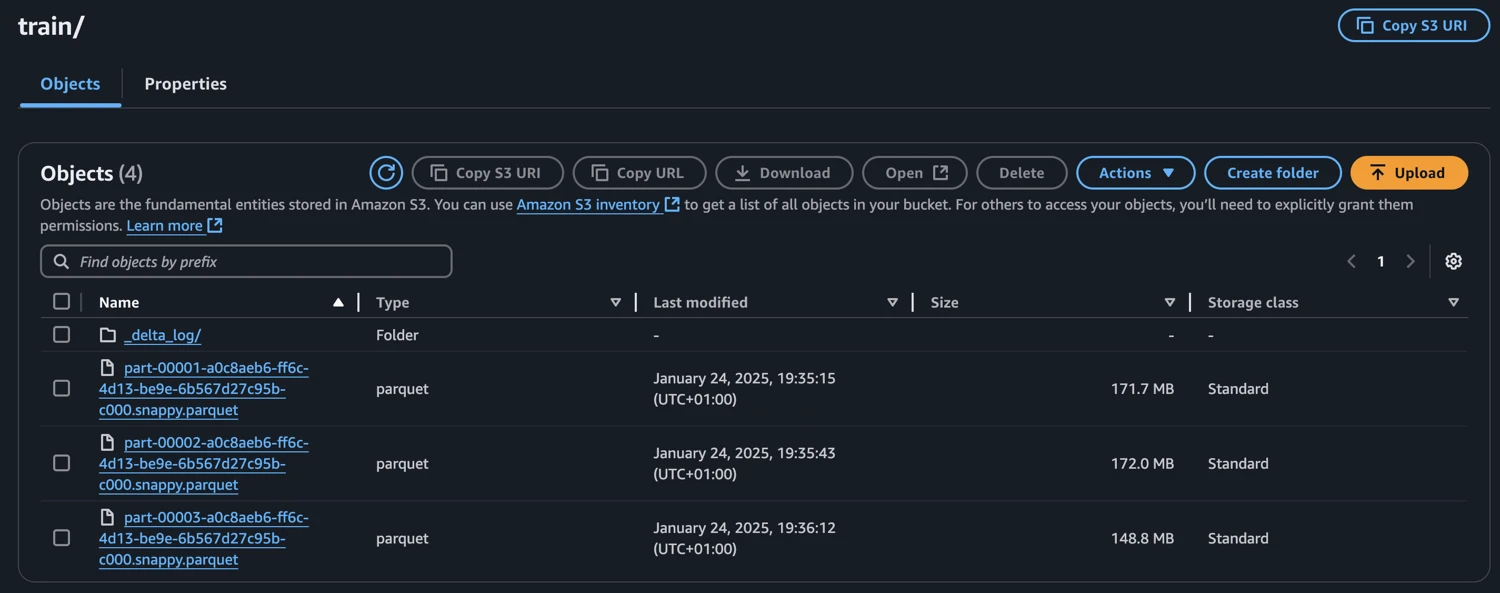

In [7]:
from IPython.display import Image

Image(filename="images/s3_delta.webp")

#### Understanding Delta:

We are going to understand a little bit better the details of Delta.

Of course, the saved files are not human readable. But we can easily read them:

In [8]:
from ml_utils.delta.delta_dataset import DeltaDataset

train_delta_dataset = DeltaDataset(path=f"{S3_URI}/train")

[2025-02-19T11:22:06Z WARN  aws_config::imds::region] failed to load region from IMDS err=failed to load IMDS session token: dispatch failure: io error: error trying to connect: tcp connect error: No route to host (os error 65): tcp connect error: No route to host (os error 65): No route to host (os error 65) (FailedToLoadToken(FailedToLoadToken { source: DispatchFailure(DispatchFailure { source: ConnectorError { kind: Io, source: hyper::Error(Connect, ConnectError("tcp connect error", Os { code: 65, kind: HostUnreachable, message: "No route to host" })), connection: Unknown } }) }))
[2025-02-19T11:22:06Z WARN  aws_config::imds::region] failed to load region from IMDS err=failed to load IMDS session token: dispatch failure: io error: error trying to connect: tcp connect error: Host is down (os error 64): tcp connect error: Host is down (os error 64): Host is down (os error 64) (FailedToLoadToken(FailedToLoadToken { source: DispatchFailure(DispatchFailure { source: ConnectorError { kind

We have the list of the full history of the data:

In [9]:
train_delta_dataset.delta_table.history()

[{'timestamp': 1739963719334,
  'operation': 'WRITE',
  'operationParameters': {'mode': 'Overwrite'},
  'operationMetrics': {'execution_time_ms': 89176,
   'num_added_files': 3,
   'num_added_rows': 650000,
   'num_partitions': 0,
   'num_removed_files': 0},
  'clientVersion': 'delta-rs.0.23.1',
  'version': 0}]

As well as the version of the data we have read:

In [10]:
train_delta_dataset.version

0

At read time, we can pick the version we want to retrieve:

In [11]:
# Overwrite the train table to illustrate the versioning. Version 1 will be created.
write_hf_dataset(path=f"{S3_URI}/train", dataset=tokenized_train_dataset)

[2025-02-19T11:22:13Z WARN  aws_config::imds::region] failed to load region from IMDS err=failed to load IMDS session token: dispatch failure: io error: error trying to connect: tcp connect error: Host is down (os error 64): tcp connect error: Host is down (os error 64): Host is down (os error 64) (FailedToLoadToken(FailedToLoadToken { source: DispatchFailure(DispatchFailure { source: ConnectorError { kind: Io, source: hyper::Error(Connect, ConnectError("tcp connect error", Os { code: 64, kind: Uncategorized, message: "Host is down" })), connection: Unknown } }) }))
[2025-02-19T11:22:13Z WARN  aws_config::imds::region] failed to load region from IMDS err=failed to load IMDS session token: dispatch failure: io error: error trying to connect: tcp connect error: Host is down (os error 64): tcp connect error: Host is down (os error 64): Host is down (os error 64) (FailedToLoadToken(FailedToLoadToken { source: DispatchFailure(DispatchFailure { source: ConnectorError { kind: Io, source: hype

In [12]:
train_delta_table_v0 = DeltaDataset(path=f"{S3_URI}/train", version=0)
train_delta_table_v1 = DeltaDataset(path=f"{S3_URI}/train", version=1)

print(train_delta_table_v0.version)
print(train_delta_table_v1.version)

[2025-02-19T11:23:17Z WARN  aws_config::imds::region] failed to load region from IMDS err=failed to load IMDS session token: dispatch failure: timeout: error trying to connect: HTTP connect timeout occurred after 1s: HTTP connect timeout occurred after 1s: timed out (FailedToLoadToken(FailedToLoadToken { source: DispatchFailure(DispatchFailure { source: ConnectorError { kind: Timeout, source: hyper::Error(Connect, HttpTimeoutError { kind: "HTTP connect", duration: 1s }), connection: Unknown } }) }))
[2025-02-19T11:23:18Z WARN  aws_config::imds::region] failed to load region from IMDS err=failed to load IMDS session token: dispatch failure: timeout: error trying to connect: HTTP connect timeout occurred after 1s: HTTP connect timeout occurred after 1s: timed out (FailedToLoadToken(FailedToLoadToken { source: DispatchFailure(DispatchFailure { source: ConnectorError { kind: Timeout, source: hyper::Error(Connect, HttpTimeoutError { kind: "HTTP connect", duration: 1s }), connection: Unknown

0
1


If we do not provide a version, we always read the latest one:

In [13]:
train_delta_table_last_version = DeltaDataset(path=f"{S3_URI}/train")
train_delta_table_last_version.version

[2025-02-19T11:23:23Z WARN  aws_config::imds::region] failed to load region from IMDS err=failed to load IMDS session token: dispatch failure: io error: error trying to connect: tcp connect error: Host is down (os error 64): tcp connect error: Host is down (os error 64): Host is down (os error 64) (FailedToLoadToken(FailedToLoadToken { source: DispatchFailure(DispatchFailure { source: ConnectorError { kind: Io, source: hyper::Error(Connect, ConnectError("tcp connect error", Os { code: 64, kind: Uncategorized, message: "Host is down" })), connection: Unknown } }) }))
[2025-02-19T11:23:23Z WARN  aws_config::imds::region] failed to load region from IMDS err=failed to load IMDS session token: dispatch failure: io error: error trying to connect: tcp connect error: Host is down (os error 64): tcp connect error: Host is down (os error 64): Host is down (os error 64) (FailedToLoadToken(FailedToLoadToken { source: DispatchFailure(DispatchFailure { source: ConnectorError { kind: Io, source: hype

1

And we can see the full history again:

In [14]:
train_delta_table_last_version.delta_table.history()

[{'timestamp': 1739964195594,
  'operation': 'WRITE',
  'operationParameters': {'mode': 'Overwrite'},
  'operationMetrics': {'execution_time_ms': 60788,
   'num_added_files': 3,
   'num_added_rows': 650000,
   'num_partitions': 0,
   'num_removed_files': 3},
  'clientVersion': 'delta-rs.0.23.1',
  'version': 1},
 {'timestamp': 1739963719334,
  'operation': 'WRITE',
  'operationParameters': {'mode': 'Overwrite'},
  'clientVersion': 'delta-rs.0.23.1',
  'operationMetrics': {'execution_time_ms': 89176,
   'num_added_files': 3,
   'num_added_rows': 650000,
   'num_partitions': 0,
   'num_removed_files': 0},
  'version': 0}]

#### Logging metadata to MLFlow:

So, at this point, we can use MLFlow to log the relevant data information, including the data URI and the data version.

Let's first point to our MLFlow Experiment:

In [15]:
import mlflow

mlflow.set_experiment("mvp-mlops-platform")

<Experiment: artifact_location='s3://ml-rd-mlflow-artifact-storage/artifacts/39', creation_time=1736873360807, experiment_id='39', last_update_time=1736873360807, lifecycle_stage='active', name='mvp-mlops-platform', tags={'mlflow.note.content': 'This is a test experiment',
 'release.version': '2.2.0',
 'use-case': 'mvp-mlops'}>

And now let's start a mlfow run and log our datasets. 

To do so, first we need to create instances of our DeltaDataset object:

In [16]:
from ml_utils.delta.delta_dataset import DeltaDataset

train_delta_dataset = DeltaDataset(path=f"{S3_URI}/train", version=1)

test_delta_dataset = DeltaDataset(path=f"{S3_URI}/test", version=0)

[2025-02-19T11:23:26Z WARN  aws_config::imds::region] failed to load region from IMDS err=failed to load IMDS session token: dispatch failure: io error: error trying to connect: tcp connect error: Host is down (os error 64): tcp connect error: Host is down (os error 64): Host is down (os error 64) (FailedToLoadToken(FailedToLoadToken { source: DispatchFailure(DispatchFailure { source: ConnectorError { kind: Io, source: hyper::Error(Connect, ConnectError("tcp connect error", Os { code: 64, kind: Uncategorized, message: "Host is down" })), connection: Unknown } }) }))
[2025-02-19T11:23:26Z WARN  aws_config::imds::region] failed to load region from IMDS err=failed to load IMDS session token: dispatch failure: io error: error trying to connect: tcp connect error: Host is down (os error 64): tcp connect error: Host is down (os error 64): Host is down (os error 64) (FailedToLoadToken(FailedToLoadToken { source: DispatchFailure(DispatchFailure { source: ConnectorError { kind: Io, source: hype

In [17]:
from ml_utils.mlflow.initializators import create_manual_run
from ml_utils.mlflow.loggers import log_datasets

# This logs default information automatically, like commit tags, etc.
with create_manual_run(
    run_name=DATASET_NAME,
    run_description="Tokenized Yelp Review Full dataset",
    use_case="MVP MLops Platform",
) as run:
    log_datasets(
        datasets={
            f"{DATASET_NAME}_train": train_delta_dataset,
            f"{DATASET_NAME}_test": test_delta_dataset,
        }
    )

2025-02-19 12:23:34.078 | INFO     | ml_utils.git.utils:get_current_git_repository:29 - Current git repository: https://github.com/elastic/mvp-mlops-platform.git
2025-02-19 12:23:34.110 | INFO     | ml_utils.git.utils:get_current_branch_name:50 - Current branch name: feature/use-infra-utilities
2025-02-19 12:23:34.144 | INFO     | ml_utils.git.utils:get_current_commit_hash:71 - Current commit hash: 3314b4f0d70a3c566d8a7446da6fe16b104ec290
2025-02-19 12:23:34.625 | INFO     | ml_utils.mlflow.initializators:create_manual_run:57 - Created MLflow manual run with name: yelp_review_full and ID: 47b6a11e4bde41abbf22845bbb19b2c8
2025-02-19 12:23:35.903 | INFO     | ml_utils.mlflow.loggers:_log_dataset_metadata:34 - Logged metadata for dataset yelp_review_full_train: path=s3://mvp-mlops-platform/data_management/yelp_review_full/train, version=1,
2025-02-19 12:25:18.618 | INFO     | ml_utils.mlflow.loggers:_log_dataset_metadata:34 - Logged metadata for dataset yelp_review_full_test: path=s3://mv

In the MLFlow UI, we can see the default tags in our active MLFlow run:

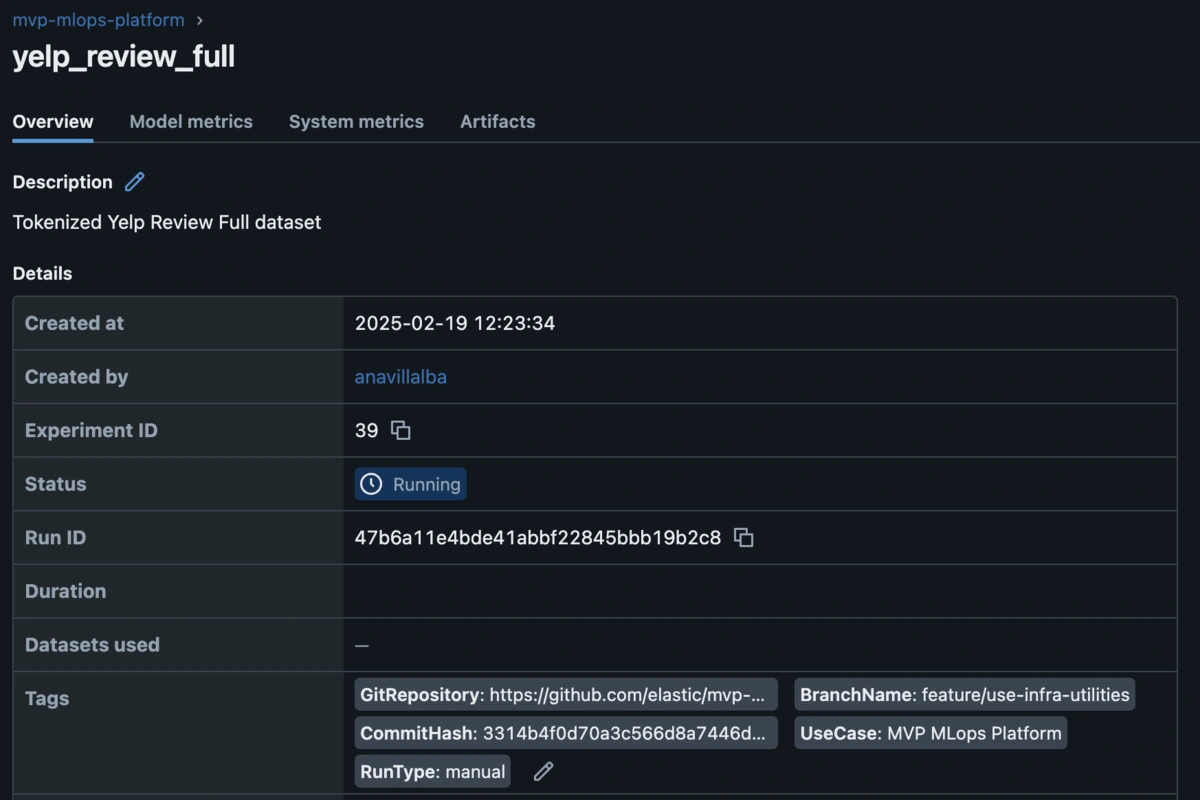

In [19]:
from IPython.display import Image

Image(filename="images/mlflow_tags.webp")

As well as the dataset metadata:

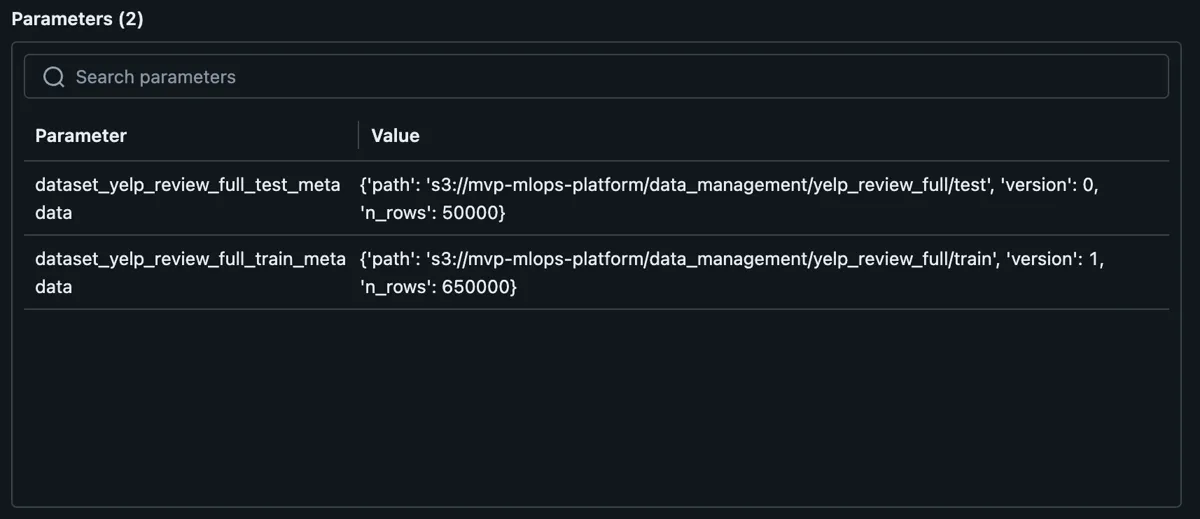

In [20]:
from IPython.display import Image

Image(filename="images/mlflow_parameters.webp")

The schemas, in the artifacts tab:

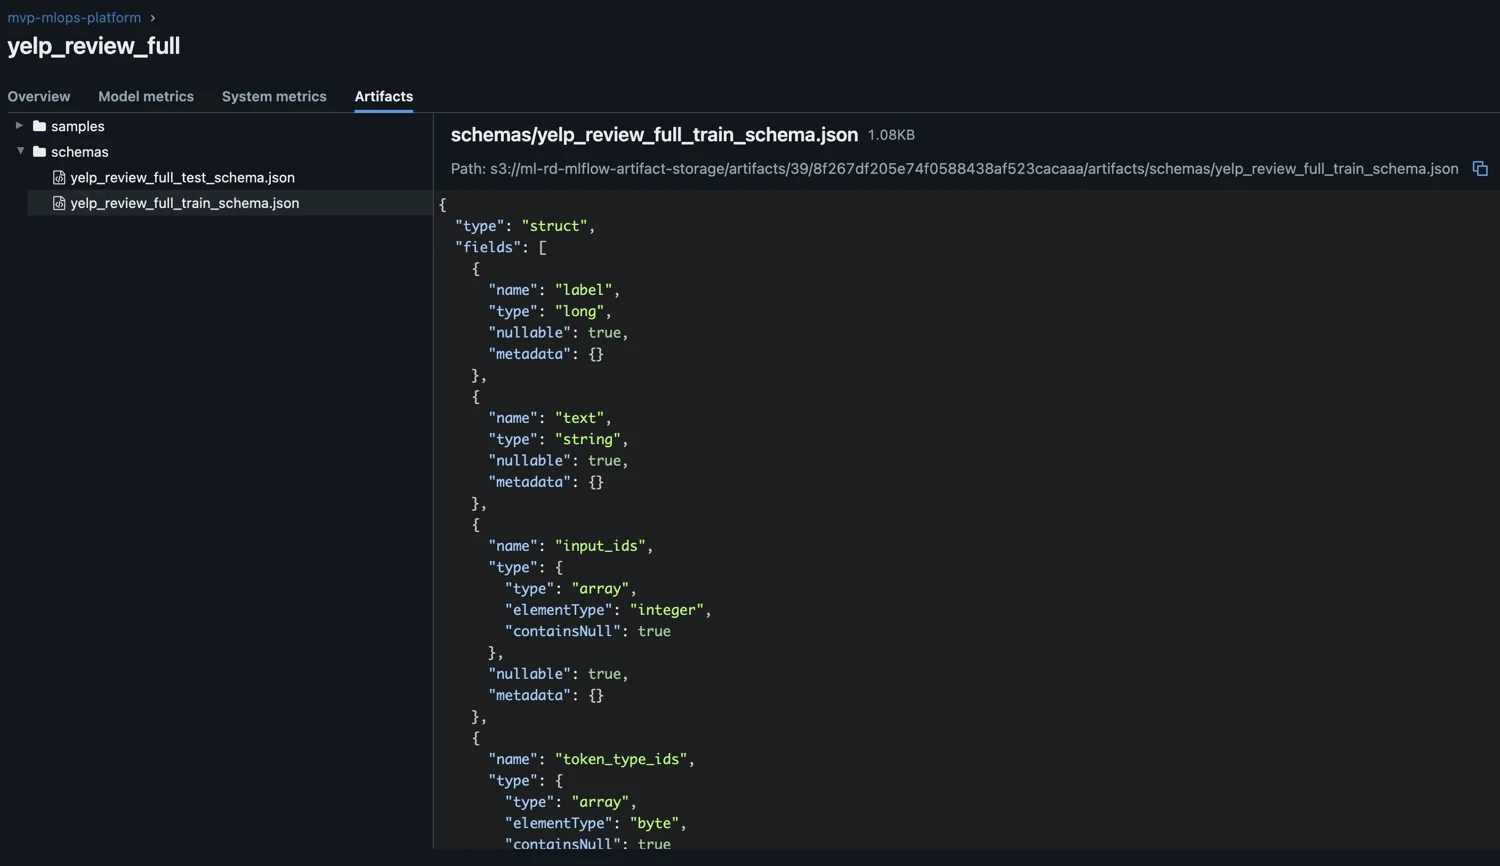

In [21]:
from IPython.display import Image

Image(filename="images/mlflow_schemas.webp")

And the samples of the data:

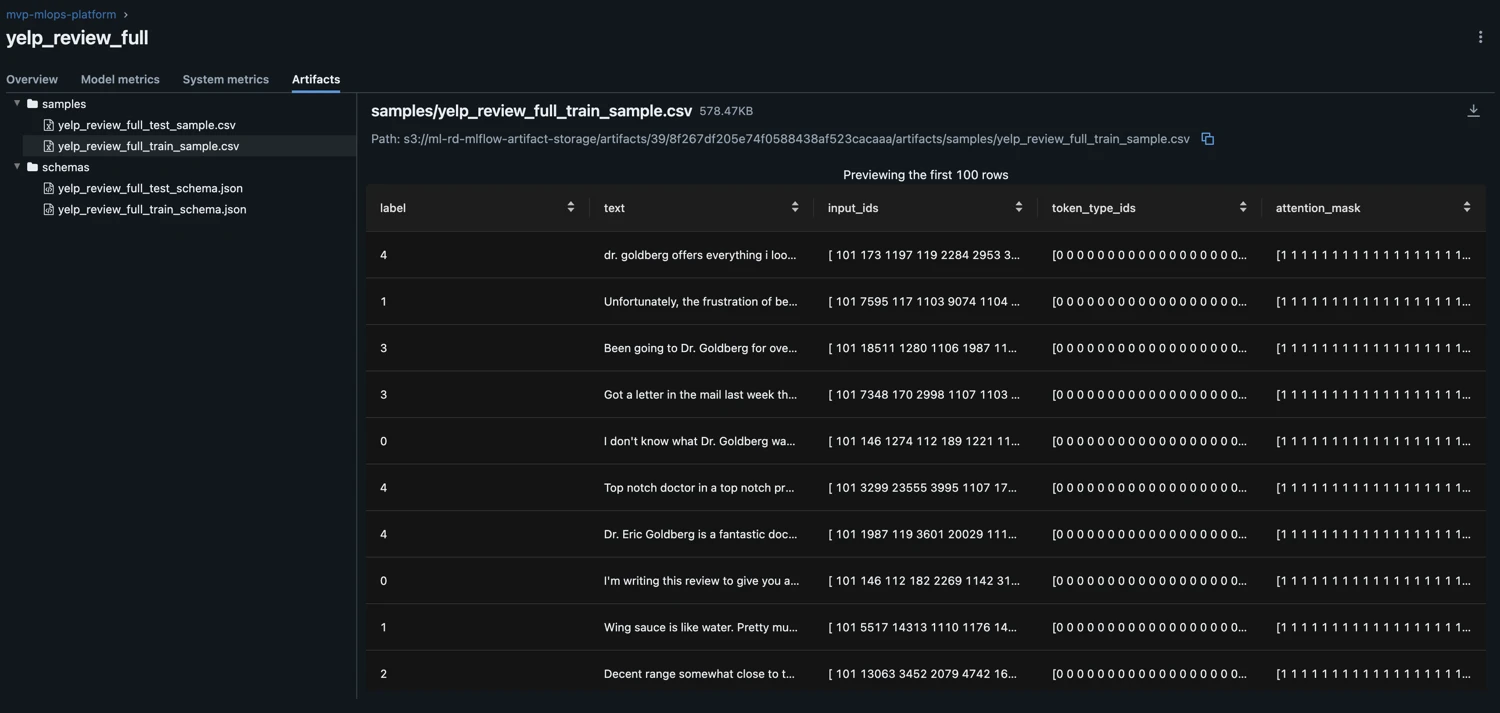

In [22]:
from IPython.display import Image

Image(filename="images/mlflow_data_sample.webp")

### 4. Train a simple NLP model:

We can then retrieve the datasets from the previous mlflow run to use them for training our model:

In [23]:
from ml_utils.mlflow.queries import get_tracked_datasets

tracked_datasets = get_tracked_datasets(run_id=run.info.run_id)
tracked_datasets

2025-02-19 12:28:23.867 | INFO     | ml_utils.mlflow.queries:get_tracked_datasets:104 - Retrieving datasets from run with ID: 47b6a11e4bde41abbf22845bbb19b2c8
2025-02-19 12:28:24.330 | INFO     | ml_utils.mlflow.queries:get_tracked_datasets:114 - Found metadata for dataset dataset_yelp_review_full_test_metadata: {'path': 's3://mvp-mlops-platform/data_management/yelp_review_full/test', 'version': 0, 'n_rows': 50000}
[2025-02-19T11:28:25Z WARN  aws_config::imds::region] failed to load region from IMDS err=failed to load IMDS session token: dispatch failure: timeout: error trying to connect: HTTP connect timeout occurred after 1s: HTTP connect timeout occurred after 1s: timed out (FailedToLoadToken(FailedToLoadToken { source: DispatchFailure(DispatchFailure { source: ConnectorError { kind: Timeout, source: hyper::Error(Connect, HttpTimeoutError { kind: "HTTP connect", duration: 1s }), connection: Unknown } }) }))
[2025-02-19T11:28:25Z WARN  aws_config::imds::region] failed to load region 

{'dataset_yelp_review_full_test_metadata': <ml_utils.delta.delta_dataset.DeltaDataset at 0x15b1403e0>,
 'dataset_yelp_review_full_train_metadata': <ml_utils.delta.delta_dataset.DeltaDataset at 0x16e13b020>}

Now let's train a model with this data. First of all, we load it as a HF Dataset:

In [24]:
train_retrieved_hf_dataset = tracked_datasets[
    f"dataset_{DATASET_NAME}_train_metadata"
].read_as_hf_dataset()
train_retrieved_hf_dataset

Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 650000
})

We will use PyTorch for training our model. As usual with `transformers`, we can create the DataLoaders:

In [25]:
from torch.utils.data import DataLoader

train_retrieved_hf_dataset = train_retrieved_hf_dataset.remove_columns(
    ["text"]
)  # already tokenized
train_retrieved_hf_dataset = train_retrieved_hf_dataset.rename_column("label", "labels")
train_retrieved_hf_dataset.set_format("torch")

small_train_dataset = train_retrieved_hf_dataset.shuffle(seed=42).select(
    range(100)
)  # pick a small sample to accelerate training
BATCH_SIZE = 8
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

Define the training hyperparameters:

In [26]:
import torch
from transformers import AdamW, BertForSequenceClassification, get_scheduler

model = BertForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=5)

LEARNING_RATE = 5e-5
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

NUM_EPOCHS = 1
num_training_steps = NUM_EPOCHS * len(train_dataloader)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/anavillalba/Code/mvp-mlops-platform/.venv/lib/python3.12/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

And finally execute the training loop. We can also use mlflow to track the hyperparameters and the train loss evolution:

In [27]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()

with mlflow.start_run(run_id=run.info.run_id):  # continue the previous run
    mlflow.log_params(
        {"num_epochs": NUM_EPOCHS, "learning_rate": LEARNING_RATE, "batch_size": BATCH_SIZE}
    )

    for epoch in range(NUM_EPOCHS):
        print(f"Training epoch {epoch + 1} of {NUM_EPOCHS}")

        for step, batch in enumerate(train_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

            mlflow.log_metric("train_loss", loss.item(), step=step + epoch * len(train_dataloader))

        mlflow.log_metric("epoch_loss", loss.item(), step=epoch)

  0%|          | 0/13 [00:00<?, ?it/s]

Training epoch 1 of 1


100%|██████████| 13/13 [01:00<00:00,  4.10s/it]2025/02/19 12:31:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run yelp_review_full at: https://us-east-1.experiments.sagemaker.aws/#/experiments/39/runs/47b6a11e4bde41abbf22845bbb19b2c8.
2025/02/19 12:31:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/39.


In the MLFlow UI we can see the evolution of the training loss:

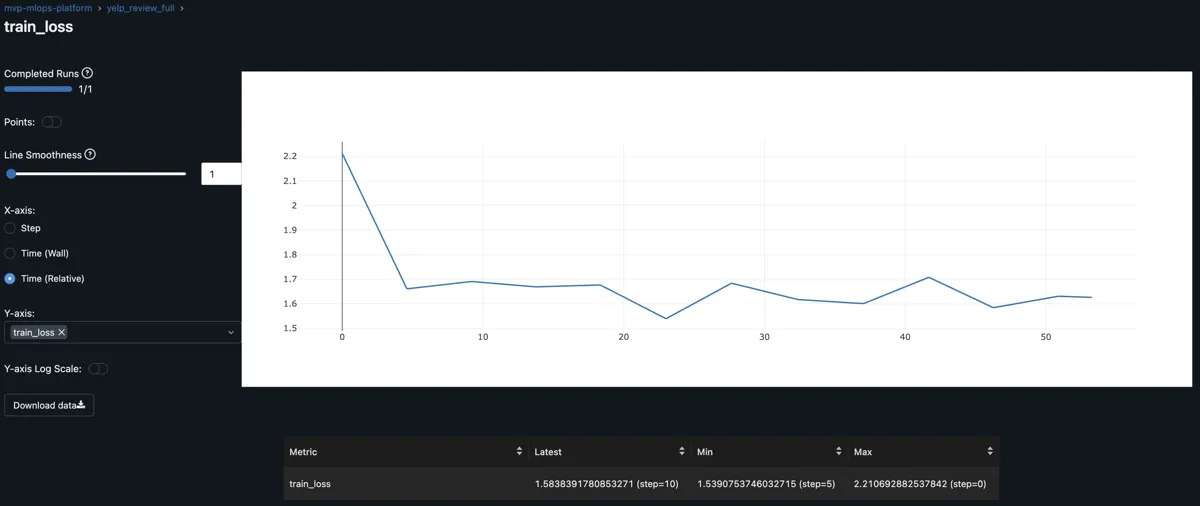

In [28]:
from IPython.display import Image

Image(filename="images/mlflow_train_loss_evolution.webp")

And we also track the hyperparameters we used:

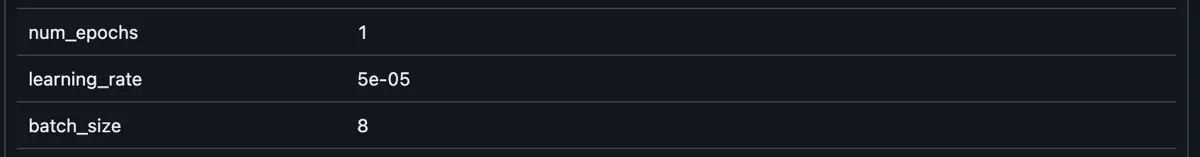

In [29]:
from IPython.display import Image

Image(filename="images/mlflow_hyperparameters.webp")

We can also log our trained model in mlflow, next to all this information. Additionally, we can also log the signature of our model, defining which inputs and outputs it expects:

In [30]:
import torch
from mlflow.models import infer_signature

example_batch = next(iter(train_dataloader))
example_inputs = {k: v.to(device) for k, v in example_batch.items()}
with torch.no_grad():
    example_outputs = model(**example_inputs)

signature = infer_signature(
    model_input={k: v.cpu().numpy() for k, v in example_inputs.items()},
    model_output=example_outputs.logits.cpu().numpy(),
)

signature

inputs: 
  ['labels': Tensor('int64', (-1,)), 'input_ids': Tensor('int64', (-1, 512)), 'token_type_ids': Tensor('int64', (-1, 512)), 'attention_mask': Tensor('int64', (-1, 512))]
outputs: 
  [Tensor('float32', (-1, 5))]
params: 
  None

In [31]:
example_input = {
    k: v[:1].cpu().numpy() for k, v in example_batch.items()
}  # to be JSON serializable

with mlflow.start_run(run_id=run.info.run_id):
    mlflow.pytorch.log_model(
        model, artifact_path="model", signature=signature, input_example=example_input
    )

2025/02/19 12:32:48 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": {
    "labels": [
      1
    ],
    "input_ids": [
      [
        101,
        1799,
        1917,
        1110,
        4489,
        117,
        146,
        1821,
        1253,
        1136,
        7351,
        119,
        146,
        9353,
        1103,
        2276,
        6553,
        7724,
        117,
        1176,
        156,
        15633,
        1116,
        119,
        1188,
        1282,
        1110,
        1198,
        1330,
        10209,
        1183,
        6898,
        1113,
        6553,
        2094,
        119,
        10839,
        131,
        1103,
        189,
        3293,
        5745,
        12635,
        1125,
        24384,
        1116,
        1104,
        16408,
        19172,
        3169,
        113,
        6994,
        114,
        1105,
        1103,
        2414,
        19359,
        1238,
        112,
        189,
   

And this is how it looks like in the MLFlow UI:

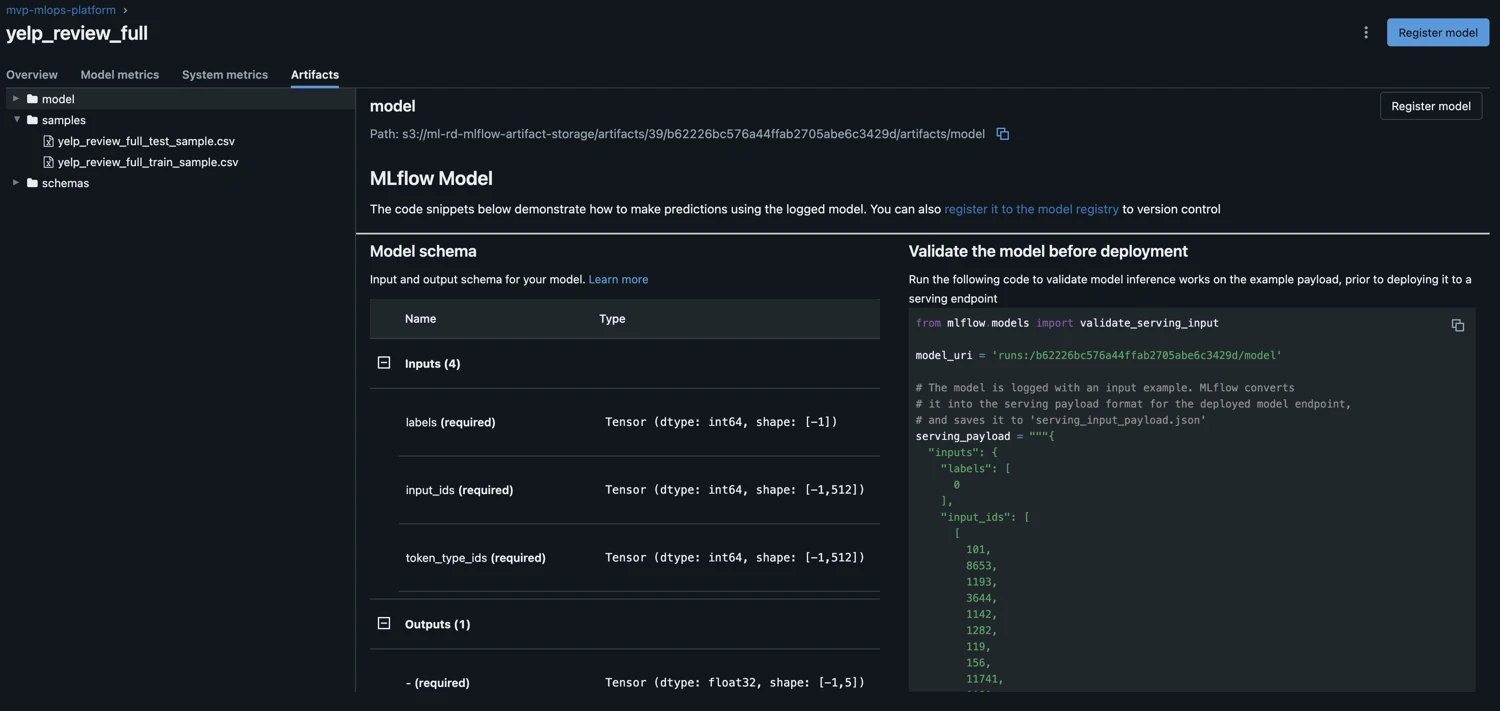

In [32]:
from IPython.display import Image

Image(filename="images/mlflow_model.webp")

When we log a model in a MLFlow run, the model is saved in the artifact storage of MLFlow. In our case, this storage is simply a S3 bucket called s3://ml-rd-mlflow-artifact-storage. 

Additionally, the code dependencies can be logged next to the model artifact. By default mlflow logs a few of them, but we can customize them. This, integrated to another core component of MLFlow called the Model Registry, makes it easy to do inference with the model in a different environment. We will extend this point in the future while evolving our MLOps Platform.

And that's it! We can do inference or evaluation afterwards with the test data, and log the metrics to mlflow (remember that we just trained for 1 epoch with 100 samples,; in order to get a good model we would need to train more epochs and with the full dataset):

In [33]:
import evaluate

test_retrieved_hf_dataset = tracked_datasets[
    f"dataset_{DATASET_NAME}_test_metadata"
].read_as_hf_dataset()

test_retrieved_hf_dataset = test_retrieved_hf_dataset.remove_columns(["text"])  # already tokenized
test_retrieved_hf_dataset = test_retrieved_hf_dataset.rename_column("label", "labels")
test_retrieved_hf_dataset.set_format("torch")

small_test_dataset = test_retrieved_hf_dataset.shuffle(seed=42).select(
    range(50)
)  # pick a small sample to accelerate eval
eval_dataloader = DataLoader(small_test_dataset, shuffle=True, batch_size=8)

metric = evaluate.load("accuracy")

logged_model = f"runs:/{run.info.run_id}/model"
loaded_model = mlflow.pytorch.load_model(logged_model)

loaded_model.eval()

with mlflow.start_run(run_id=run.info.run_id):
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            outputs = loaded_model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])

    accuracy = metric.compute()["accuracy"]
    mlflow.log_metric("test_accuracy", accuracy)

2025/02/19 12:34:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run yelp_review_full at: https://us-east-1.experiments.sagemaker.aws/#/experiments/39/runs/47b6a11e4bde41abbf22845bbb19b2c8.
2025/02/19 12:34:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/39.


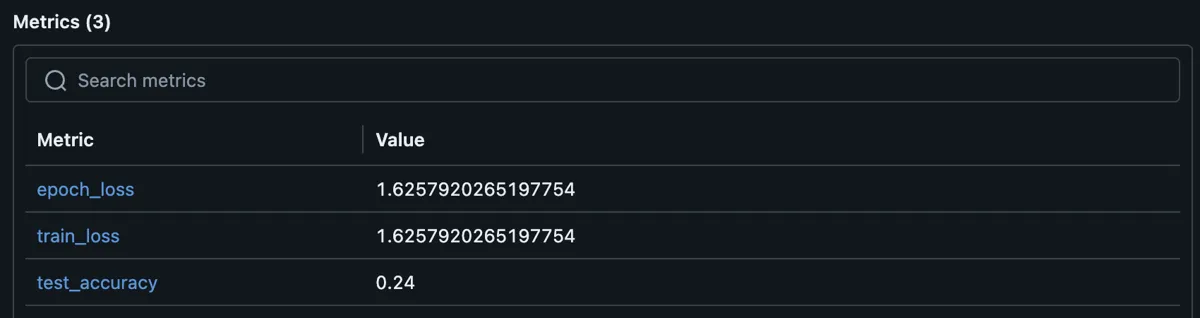

In [34]:
from IPython.display import Image

Image(filename="images/mlflow_accuracy.webp")

At this point, from this running example we know:
- What data we used for training and testing the model and how it looks like (data samples, schemas)
- What code we used
- What hyperparameters we used 
- How the training loss evolved
- What test metrics we got
- Where is the trained model stored, as well as the dependencies that you need to run inference with them.


## Conclusion

This notebook demonstrates the benefits of using MLFlow as our metadata tracker as well as a standard data format like Delta to enhance the MLOps maturity of our projects.